In [1]:
import numpy as np
import oceanDAS as odas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal, stats

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/'

plt.rc('font', size=12)

def calcPSD(rawstrain,metadata,frq_noise):
#     frq_noise = calcnoisefloor(rawstrain,metadata)
    rawstrain = (rawstrain - rawstrain[0])/(1e-6) #microStrain to strain for units
    frq_w,psd_w = signal.welch(rawstrain,fs=metadata['fs'],window='hann',nperseg=metadata['fs']*60,detrend=False)
    psd_w = 20*np.log10(psd_w); # dB rel uE
    psd_nonoise = psd_w.copy()
    psd_nonoise[frq_w>frq_noise]=np.nan
    return frq_w,psd_w,psd_nonoise

# def calcnoisefloor(rawstrain,metadata):
#     # calculate 1 dof FFT
#     ns = len(rawstrain)
#     frq = np.fft.rfftfreq(ns,d=1./metadata['fs']) # frequency in Hz
#     psd = 20 * np.log10( (2/ns) * abs(np.fft.rfft(rawstrain * np.hamming(ns))) )

#     # bin the data by frequency to find a rough noise floor
#     frq_bins = np.arange(0.2,1,0.02)
#     psd_bins, _, _ = stats.binned_statistic(frq,psd, 'median', bins=frq_bins)
#     # calculate the slope of the PSD between bins
#     slp = np.absolute(psd_bins[:-1]-psd_bins[1:])
#     # calculate the variability in each bin
#     std_bins, _, _ = stats.binned_statistic(frq,psd, 'std', bins=frq_bins)
#     std_bins = np.mean(std_bins)/5
#     # if slope is less than STD then we've hit noise floor
#     frq_noise = [ n for n,i in enumerate(slp) if i<std_bins][0]
#     frq_noise = frq_bins[frq_noise]

#     return frq_noise

In [2]:
# load useful info like depth and noise floor freq for each site
h, f_noise, clrs = odas.all_line_info()
plt.rcParams['lines.linewidth'] = 2

# Load in one channel at each site (or load stack and take out one channel)
# Duck
pname = 'DuckNC_Glover/'
fname = 'decimator_2021-11-20_20.25.43_UTC_001612.h5'
rawstrain,das_time,chnl,depth,metadata = odas.loadDuck(pname,fname)
ns,nx = rawstrain.shape
rawstrain = rawstrain[:,int(nx/2)]
frq_duck,psd_duck_raw,psd_duck_nn = calcPSD(rawstrain,metadata,f_noise[0])

# KNO
pname = 'KNO_Glover/'
fname = 'KNOFIber2_SKT3_copier3_2023-01-21_21-36-37_UTC_002536.h5'
rawstrain,das_time,chnl,depth,metadata = odas.loadKNO(pname,fname,fiber=2)
rawstrain = rawstrain[:,-20]
frq_kno,psd_kno_raw,psd_kno_nn = calcPSD(rawstrain,metadata,f_noise[1])

# MVCO
pname = 'MarthasVineyard_Smith/'
fname = '20221227000000_f0200Hz_dx4m_nch2112_f2Hz.nc'
rawstrain,das_time,chnl,metadata = odas.loadMV(pname,fname)
rawstrain = rawstrain[:,1696]
frq_mvco,psd_mvco_raw,psd_mvco_nn = calcPSD(rawstrain,metadata,f_noise[2])

# Oliktok
pname = 'OliktokPoint_Smith/'
fname = 'rawdata/10840/CODAS.D4__20211110_170007.174__chn-10840.sac'
rawstrain,das_time,h_oli,metadata = odas.loadOliktokSingle(pname,fname)
frq_oli,psd_oli_raw,psd_oli_nn = calcPSD(rawstrain,metadata,0.3)

# Homer
pname = 'HomerAK_Williams/'
fname = 'GCI_TERRA_2p5Hz_data.h5'
onechn = True
rawstrain,das_time,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
frq_hom,psd_hom_raw,psd_hom_nn = calcPSD(rawstrain,metadata,f_noise[4])

# Florence
pname = 'FlorenceOR_Ifju/'
fname = 'mode9copier_2022-09-28_22-42-54_UTC_000287.h5'
rawstrain,das_time,chnl,depth,metadata = odas.loadFlorence(pname,fname)
ns,nx = rawstrain.shape
rawstrain = rawstrain[:,int(nx/2)]
frq_flo,psd_flo_raw,psd_flo_nn = calcPSD(rawstrain,metadata,f_noise[5])





Text(0, 0.5, 'PSD (dB rel 1 uE^2/Hz)')

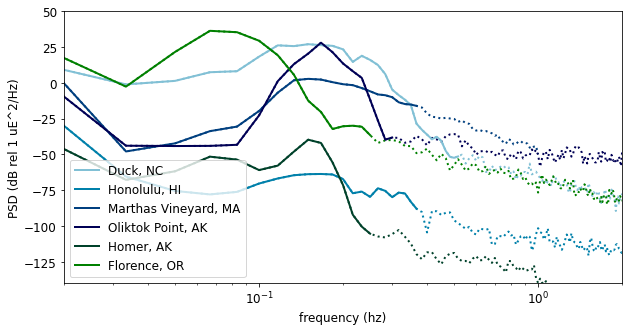

In [3]:
plt.figure(figsize=(10,5))
plt.plot(frq_duck,psd_duck_raw,':',c = clrs[0,:])
plt.plot(frq_kno,psd_kno_raw,':',c = clrs[1,:])
plt.plot(frq_mvco,psd_mvco_raw,':',c = clrs[2,:])
plt.plot(frq_oli,psd_oli_raw,':',c = clrs[3,:])
plt.plot(frq_hom,psd_hom_raw,':',c = clrs[4,:])
plt.plot(frq_flo,psd_flo_raw,':',c = clrs[5,:])

plt.plot(frq_duck,psd_duck_nn,label='Duck, NC',c = clrs[0,:])
plt.plot(frq_kno,psd_kno_nn,label='Honolulu, HI',c = clrs[1,:])
plt.plot(frq_mvco,psd_mvco_nn,label='Martha''s Vineyard, MA',c = clrs[2,:])
plt.plot(frq_oli,psd_oli_nn,label='Oliktok Point, AK',c = clrs[3,:])
plt.plot(frq_hom,psd_hom_nn,label='Homer, AK',c = clrs[4,:])
plt.plot(frq_flo,psd_flo_nn,label='Florence, OR',c = clrs[5,:])
plt.legend()
plt.xscale('log')
plt.xlim([0.02,2])
plt.ylim([-140,50])
plt.xlabel('frequency (hz)')
plt.ylabel('PSD (dB rel 1 uE^2/Hz)')


In [4]:
# # Homer
# pname = 'HomerAK_Williams/'
# fname = 'GCI_TERRA_2p5Hz_data.h5'
# onechn = True
# rawstrain,das_time,chnl,depth,metadata = odas.loadHomer(pname,fname,onechn)
# rawstrain = (rawstrain - rawstrain[0])/(1e-6) #microStrain
# ns = len(rawstrain)
# frq_hom = np.fft.rfftfreq(ns,d=1./metadata['fs']) # frequency in Hz
# psd_hom_raw = 20 * np.log10( (2/ns) * abs(np.fft.rfft(rawstrain * np.hamming(ns))) )

# plt.figure(figsize=(7,5))
# plt.plot(frq_hom,psd_hom_raw,'k')
# # plt.xscale('log')
# plt.xlim([0.02,1])

# # bin the data by frequency - we dont need a perfect freq, just a rough noise floor
# frq_bins = np.arange(0.15,1,0.025)
# psd_bins, _, _ = stats.binned_statistic(frq_hom,psd_hom_raw, 'median', bins=frq_bins)
# print(psd_bins)
# # calculate the slope of the PSD between bins
# slp = np.absolute(psd_bins[:-1]-psd_bins[1:])
# # calculate the variability in each bin
# std_bins, _, _ = stats.binned_statistic(frq_hom,psd_hom_raw, 'std', bins=frq_bins)
# print(std_bins)

# std_bins = np.mean(std_bins)
# # if slope is less than STD then we've hit noise floor
# frq_noise = [ n for n,i in enumerate(slp) if i<std_bins][0]
# frq_noise = frq_bins[frq_noise]

# print(frq_noise)
